<a href="https://colab.research.google.com/github/SainiThapa/SEMINAR-and-RESEARCH/blob/main/1st%20Sem/AQI_PM25_DomesticFuel_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def calculate_pm25_aqi(pm):
    if pm < 0:
        return 0
    breakpoints = [
        (0.0, 12.0, 0, 50),      # Good
        (12.1, 35.4, 51, 100),   # Moderate
        (35.5, 55.4, 101, 150),  # Unhealthy for Sensitive Groups
        (55.5, 150.4, 151, 200), # Unhealthy
        (150.5, 250.4, 201, 300),# Very Unhealthy
        (250.5, 350.4, 301, 400),# Hazardous (lower)
        (350.5, 500.4, 401, 500) # Hazardous (upper)
    ]
    for low, high, aqi_low, aqi_high in breakpoints:
        if low <= pm <= high:
            return ((aqi_high - aqi_low) / (high - low)) * (pm - low) + aqi_low
    return 500  # Cap at 500 for values >500.4


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# STEP 1: DATA ACQUISITION AND LOADING\

In [30]:
print("\n[STEP 1] DATA ACQUISITION")
print("-" * 80)

# Load the datasets
print("Loading PM 2.5 concentration data...")
pm25_path='/content/drive/MyDrive/TU/1stSEM/Datasets/Concenterations_of_fine_particulate_matter_PM2.5_2015-19.csv'
pm25_df = pd.read_csv(pm25_path)
print(f"✓ PM 2.5 data loaded: {pm25_df.shape[0]} rows, {pm25_df.shape[1]} columns")

fuel_path='/content/drive/MyDrive/TU/1stSEM/Datasets/Proportion_of_population_with_primary_reliance_on_fuels_and_technologies_for_cooking_by_fuel_type.csv'
print("\nLoading cooking fuel data...")
fuel_df = pd.read_csv(fuel_path)
print(f"✓ Fuel data loaded: {fuel_df.shape[0]} rows, {fuel_df.shape[1]} columns")

# Display basic information
print("\n" + "=" * 80)
print("PM 2.5 Dataset Preview:")
print("-" * 80)
print(pm25_df.head())
print("\nColumn names:", pm25_df.columns.tolist())

print("\n" + "=" * 80)
print("Cooking Fuel Dataset Preview:")
print("-" * 80)
print(fuel_df.head())
print("\nColumn names:", fuel_df.columns.tolist())


[STEP 1] DATA ACQUISITION
--------------------------------------------------------------------------------
Loading PM 2.5 concentration data...
✓ PM 2.5 data loaded: 1930 rows, 34 columns

Loading cooking fuel data...
✓ Fuel data loaded: 2880 rows, 34 columns

PM 2.5 Dataset Preview:
--------------------------------------------------------------------------------
  IndicatorCode                                          Indicator ValueType  \
0       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   
1       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   
2       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   
3       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   
4       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   

  ParentLocationCode ParentLocation Location type SpatialDimValueCode  \
0                AMR       Americas       Country                 TTO   
1     

# STEP 2: DATA CLEANING AND PREPARATION

In [31]:
print("\n\n[STEP 2] DATA CLEANING AND PREPARATION")
print("-" * 80)

# Clean PM 2.5 data
print("\nCleaning PM 2.5 data...")
pm25_clean = pm25_df[['Location', 'Period', 'Dim1', 'FactValueNumeric', 'FactValueNumericLow', 'FactValueNumericHigh',
                       'ParentLocation']].copy()
pm25_clean.columns = ['Country', 'Year', 'Residence_Type', 'PM25_Concentration', 'PM25_Low', 'PM25_High',
                      'Region']
pm25_clean = pm25_clean[pm25_clean['Year'] == 2019]  # Focus on 2019
pm25_clean = pm25_clean.dropna(subset=['PM25_Concentration'])
print(f"✓ PM 2.5 cleaned: {pm25_clean.shape[0]} records for 2019")

# Clean fuel data
print("\nCleaning cooking fuel data...")
fuel_clean = fuel_df[['Location', 'Period', 'Dim1', 'Dim2', 'FactValueNumeric',
                       'ParentLocation']].copy()
fuel_clean.columns = ['Country', 'Year', 'Residence_Type', 'Fuel_Type',
                     'Percentage', 'Region']
fuel_clean = fuel_clean[fuel_clean['Year'] == 2019]  # Focus on 2019
fuel_clean = fuel_clean.dropna(subset=['Percentage'])
print(f"✓ Fuel data cleaned: {fuel_clean.shape[0]} records for 2019")

# Categorize fuels as clean vs unclean
print("\nCategorizing fuels...")
clean_fuels = ['Gas', 'Electricity']
unclean_fuels = ['Biomass', 'Kerosene', 'Charcoal', 'Coal']

fuel_clean['Fuel_Category'] = fuel_clean['Fuel_Type'].apply(
    lambda x: 'Clean' if x in clean_fuels else
             ('Unclean' if x in unclean_fuels else 'Other')
)

# Aggregate fuel data by country and residence type
print("\nAggregating fuel usage by category...")
fuel_agg = fuel_clean.groupby(['Country', 'Residence_Type', 'Fuel_Category',
                                'Region'])['Percentage'].sum().reset_index()

# Pivot to get clean and unclean percentages
fuel_pivot = fuel_agg.pivot_table(
    index=['Country', 'Residence_Type', 'Region'],
    columns='Fuel_Category',
    values='Percentage',
    fill_value=0
).reset_index()
print(fuel_agg)


print(f"✓ Fuel data aggregated: {fuel_pivot.shape[0]} records")
print(fuel_pivot)



[STEP 2] DATA CLEANING AND PREPARATION
--------------------------------------------------------------------------------

Cleaning PM 2.5 data...
✓ PM 2.5 cleaned: 386 records for 2019

Cleaning cooking fuel data...
✓ Fuel data cleaned: 2880 records for 2019

Categorizing fuels...

Aggregating fuel usage by category...
         Country Residence_Type Fuel_Category                 Region  \
0    Afghanistan          Rural         Clean  Eastern Mediterranean   
1    Afghanistan          Rural       Unclean  Eastern Mediterranean   
2    Afghanistan          Total         Clean  Eastern Mediterranean   
3    Afghanistan          Total       Unclean  Eastern Mediterranean   
4    Afghanistan          Urban         Clean  Eastern Mediterranean   
..           ...            ...           ...                    ...   
955     Zimbabwe          Rural       Unclean                 Africa   
956     Zimbabwe          Total         Clean                 Africa   
957     Zimbabwe          Tota

# STEP 3: MERGE DATASETS

In [32]:
print("\n\n[STEP 3] MERGING DATASETS")
print("-" * 80)

# Merge PM 2.5 with fuel data
merged_df = pd.merge(
    pm25_clean,
    fuel_pivot,
    on=['Country', 'Residence_Type'],
    how='inner'
)

# Calculate AQI for mean, low, high
merged_df['AQI'] = merged_df['PM25_Concentration'].apply(calculate_pm25_aqi)
merged_df['AQI_Low'] = merged_df['PM25_Low'].apply(calculate_pm25_aqi)
merged_df['AQI_High'] = merged_df['PM25_High'].apply(calculate_pm25_aqi)

print(merged_df)

print(f"✓ Datasets merged: {merged_df.shape[0]} records with both PM 2.5 and fuel data")
print(f"✓ Countries covered: {merged_df['Country'].nunique()}")
print(f"✓ Regions covered: {merged_df['Region_x'].nunique()}")

# Display merged data summary
print("\nMerged Dataset Summary:")
print(merged_df.describe())



[STEP 3] MERGING DATASETS
--------------------------------------------------------------------------------
                 Country  Year Residence_Type  PM25_Concentration  PM25_Low  \
0    Trinidad and Tobago  2019          Rural               10.02      7.44   
1                Grenada  2019          Urban               10.22      7.15   
2                 Guyana  2019          Rural               10.33      5.34   
3                Austria  2019          Rural               10.34     10.00   
4    Trinidad and Tobago  2019          Urban               10.39      8.17   
..                   ...   ...            ...                 ...       ...   
307                Spain  2019          Urban                9.77      9.56   
308                Haiti  2019          Urban                9.78      5.37   
309             Barbados  2019          Urban                9.83      6.91   
310              Grenada  2019          Rural                9.84      6.93   
311   Russian Federati

# STEP 4: EXPLORATORY DATA ANALYSIS

In [33]:
print("\n\n[STEP 4] EXPLORATORY DATA ANALYSIS")
print("-" * 80)

# Calculate correlation
if 'Clean' in merged_df.columns and 'Unclean' in merged_df.columns:
    corr_clean = merged_df[['PM25_Concentration', 'Clean']].corr().iloc[0, 1]
    corr_unclean = merged_df[['PM25_Concentration', 'Unclean']].corr().iloc[0, 1]

    print(f"\nCorrelation Analysis:")
    print(f"  • Clean fuels vs PM 2.5: {corr_clean:.4f}")
    print(f"  • Unclean fuels vs PM 2.5: {corr_unclean:.4f}")

# Regional analysis
print("\n\nPM 2.5 Concentration by Region:")
regional_avg = merged_df.groupby('Region_x')['PM25_Concentration'].mean().sort_values(ascending=False)
for region, value in regional_avg.items():
    print(f"  • {region}: {value:.2f} μg/m³")




[STEP 4] EXPLORATORY DATA ANALYSIS
--------------------------------------------------------------------------------

Correlation Analysis:
  • Clean fuels vs PM 2.5: -0.1402
  • Unclean fuels vs PM 2.5: 0.1979


PM 2.5 Concentration by Region:
  • Eastern Mediterranean: 36.70 μg/m³
  • South-East Asia: 29.15 μg/m³
  • Africa: 29.11 μg/m³
  • Europe: 20.45 μg/m³
  • Western Pacific: 14.58 μg/m³
  • Americas: 13.55 μg/m³


# STEP 5: VISUALIZATIONS

**Visualization 1: PM 2.5 vs Clean Fuel Usage**

✓ Scatter plots saved as 'fuel_vs_pm25_scatter.png'


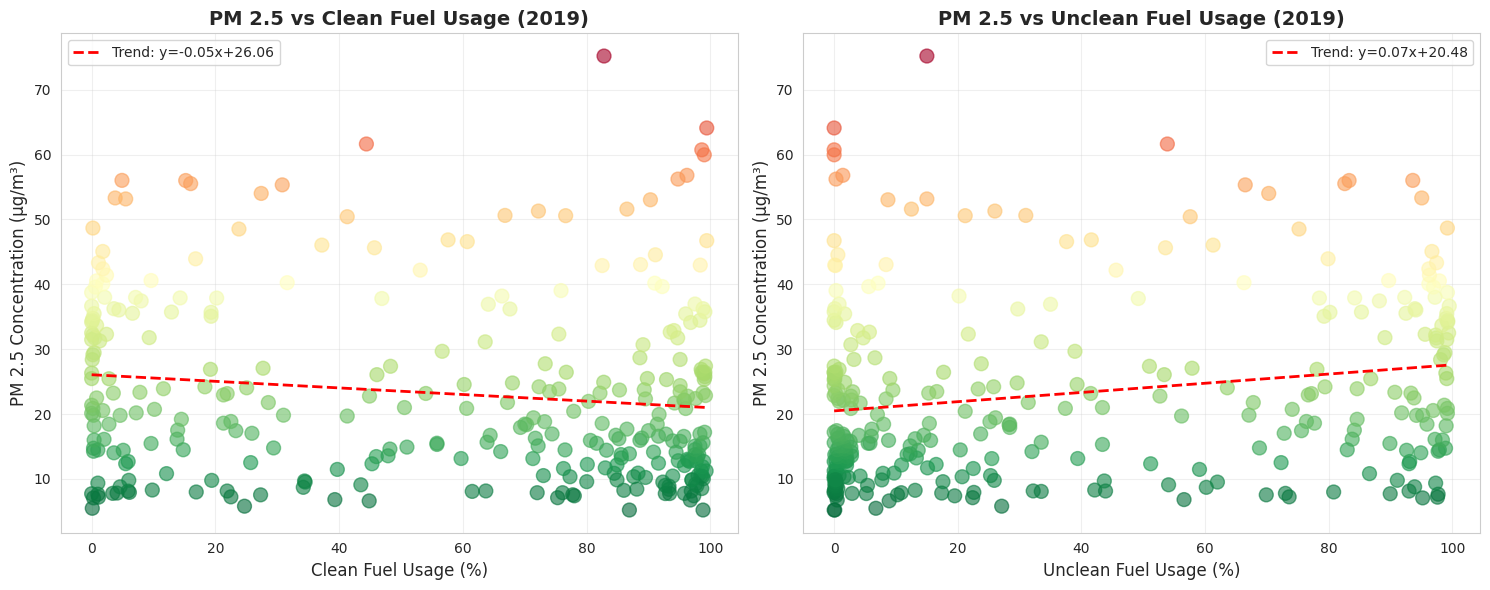

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

if 'Clean' in merged_df.columns:
    axes[0].scatter(merged_df['Clean'], merged_df['PM25_Concentration'],
                   alpha=0.6, c=merged_df['PM25_Concentration'],
                   cmap='RdYlGn_r', s=100)
    axes[0].set_xlabel('Clean Fuel Usage (%)', fontsize=12)
    axes[0].set_ylabel('PM 2.5 Concentration (μg/m³)', fontsize=12)
    axes[0].set_title('PM 2.5 vs Clean Fuel Usage (2019)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(merged_df['Clean'], merged_df['PM25_Concentration'], 1)
    p = np.poly1d(z)
    axes[0].plot(merged_df['Clean'].sort_values(),
                p(merged_df['Clean'].sort_values()),
                "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    axes[0].legend()

if 'Unclean' in merged_df.columns:
    axes[1].scatter(merged_df['Unclean'], merged_df['PM25_Concentration'],
                   alpha=0.6, c=merged_df['PM25_Concentration'],
                   cmap='RdYlGn_r', s=100)
    axes[1].set_xlabel('Unclean Fuel Usage (%)', fontsize=12)
    axes[1].set_ylabel('PM 2.5 Concentration (μg/m³)', fontsize=12)
    axes[1].set_title('PM 2.5 vs Unclean Fuel Usage (2019)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(merged_df['Unclean'], merged_df['PM25_Concentration'], 1)
    p = np.poly1d(z)
    axes[1].plot(merged_df['Unclean'].sort_values(),
                p(merged_df['Unclean'].sort_values()),
                "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    axes[1].legend()

plt.tight_layout()
plt.savefig('fuel_vs_pm25_scatter.png', dpi=300, bbox_inches='tight')
print("✓ Scatter plots saved as 'fuel_vs_pm25_scatter.png'")
plt.show()

**Visualization 2: Regional Comparison**

✓ Regional comparison saved as 'regional_comparison.png'


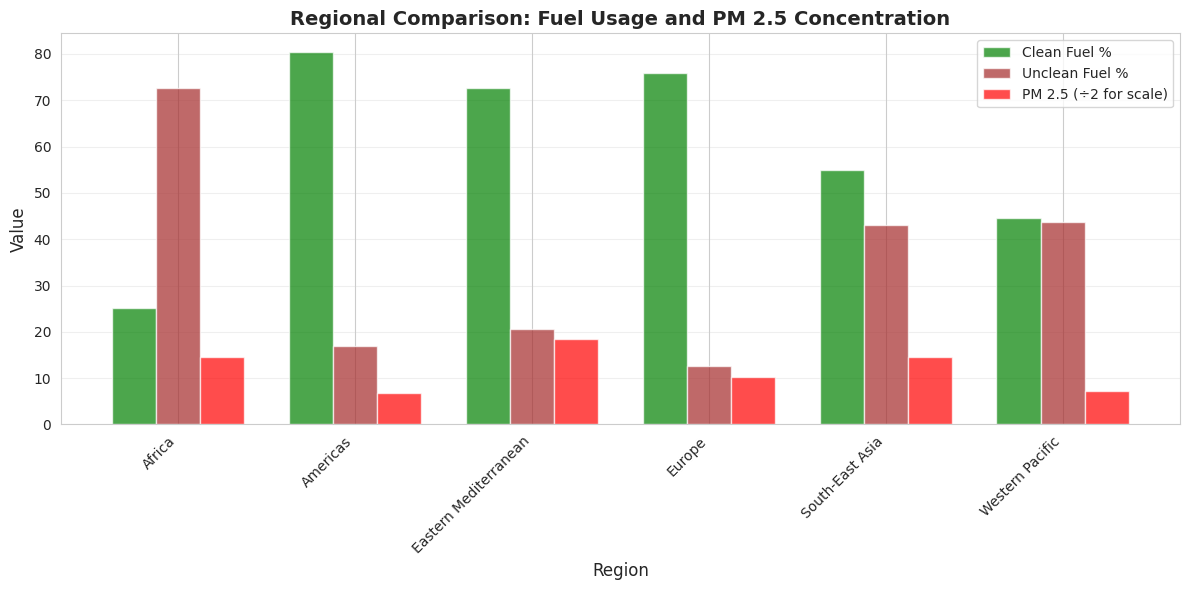

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
regional_data = merged_df.groupby('Region_x').agg({
    'PM25_Concentration': 'mean',
    'Clean': 'mean',
    'Unclean': 'mean'
}).reset_index()

x = np.arange(len(regional_data))
width = 0.25

ax.bar(x - width, regional_data['Clean'], width, label='Clean Fuel %',
       color='green', alpha=0.7)
ax.bar(x, regional_data['Unclean'], width, label='Unclean Fuel %',
       color='brown', alpha=0.7)
ax.bar(x + width, regional_data['PM25_Concentration']/2, width,
       label='PM 2.5 (÷2 for scale)', color='red', alpha=0.7)

ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Regional Comparison: Fuel Usage and PM 2.5 Concentration',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(regional_data['Region_x'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('regional_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Regional comparison saved as 'regional_comparison.png'")
plt.show()

**Visualization 3: Urban vs Rural Comparison**

✓ Urban/Rural comparison saved as 'urban_rural_comparison.png'


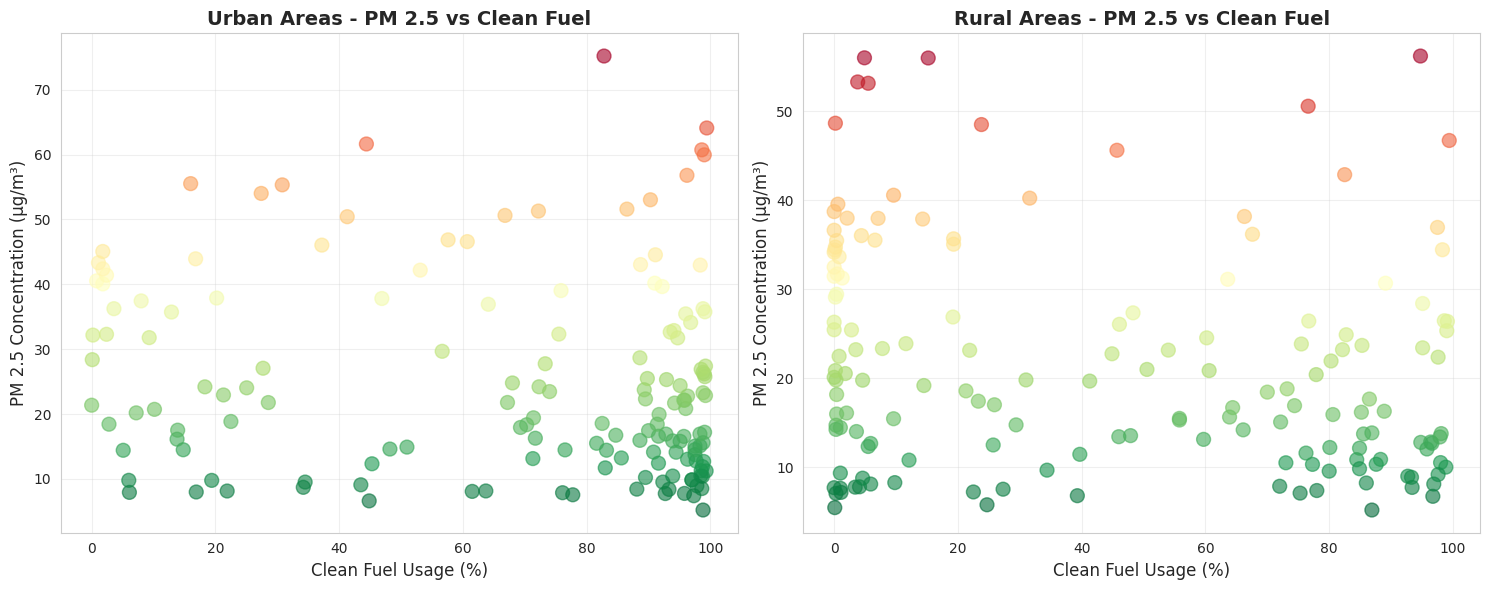

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, residence in enumerate(['Urban', 'Rural']):
    residence_data = merged_df[merged_df['Residence_Type'] == residence]

    if len(residence_data) > 0 and 'Clean' in residence_data.columns:
        axes[idx].scatter(residence_data['Clean'],
                         residence_data['PM25_Concentration'],
                         alpha=0.6, s=100,
                         c=residence_data['PM25_Concentration'],
                         cmap='RdYlGn_r')
        axes[idx].set_xlabel('Clean Fuel Usage (%)', fontsize=12)
        axes[idx].set_ylabel('PM 2.5 Concentration (μg/m³)', fontsize=12)
        axes[idx].set_title(f'{residence} Areas - PM 2.5 vs Clean Fuel',
                           fontsize=14, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('urban_rural_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Urban/Rural comparison saved as 'urban_rural_comparison.png'")
plt.show()

# STEP 6: MACHINE LEARNING ANALYSIS



In [38]:
print("\n\n[STEP 6] MACHINE LEARNING ANALYSIS")
print("-" * 80)

# Prepare features for ML
if 'Clean' in merged_df.columns and 'Unclean' in merged_df.columns:
    ml_df = merged_df[['Clean', 'Unclean', 'PM25_Concentration']].dropna()

    if len(ml_df) > 10:
        X = ml_df[['Clean', 'Unclean']]
        y = ml_df['PM25_Concentration']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Linear Regression
        print("\nLinear Regression Model:")
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_r2 = r2_score(y_test, lr_pred)
        lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

        print(f"  • R² Score: {lr_r2:.4f}")
        print(f"  • RMSE: {lr_rmse:.4f}")
        print(f"  • Clean Fuel Coefficient: {lr_model.coef_[0]:.4f}")
        print(f"  • Unclean Fuel Coefficient: {lr_model.coef_[1]:.4f}")

        # Random Forest
        print("\nRandom Forest Model:")
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_r2 = r2_score(y_test, rf_pred)
        rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

        print(f"  • R² Score: {rf_r2:.4f}")
        print(f"  • RMSE: {rf_rmse:.4f}")
        print(f"  • Feature Importances:")
        for feat, imp in zip(['Clean Fuel', 'Unclean Fuel'],
                            rf_model.feature_importances_):
            print(f"    - {feat}: {imp:.4f}")



[STEP 6] MACHINE LEARNING ANALYSIS
--------------------------------------------------------------------------------

Linear Regression Model:
  • R² Score: 0.0858
  • RMSE: 11.8468
  • Clean Fuel Coefficient: 0.1734
  • Unclean Fuel Coefficient: 0.2176

Random Forest Model:
  • R² Score: -0.3068
  • RMSE: 14.1643
  • Feature Importances:
    - Clean Fuel: 0.5258
    - Unclean Fuel: 0.4742


# Predicted vs Actual for Linear Regression

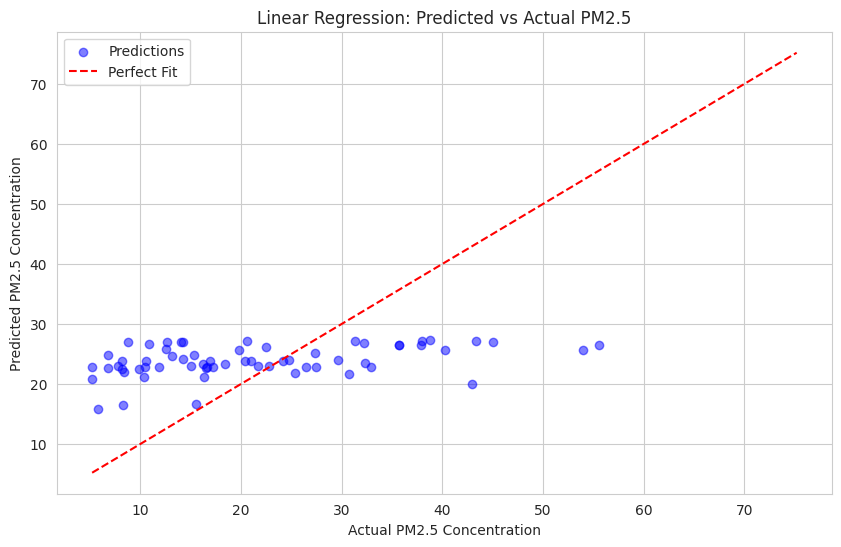

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual PM2.5 Concentration')
plt.ylabel('Predicted PM2.5 Concentration')
plt.title('Linear Regression: Predicted vs Actual PM2.5')
plt.legend()
plt.grid(True)
plt.savefig('lr_pred_vs_actual.png')
plt.show()

# Predicted vs Actual for Random Forest

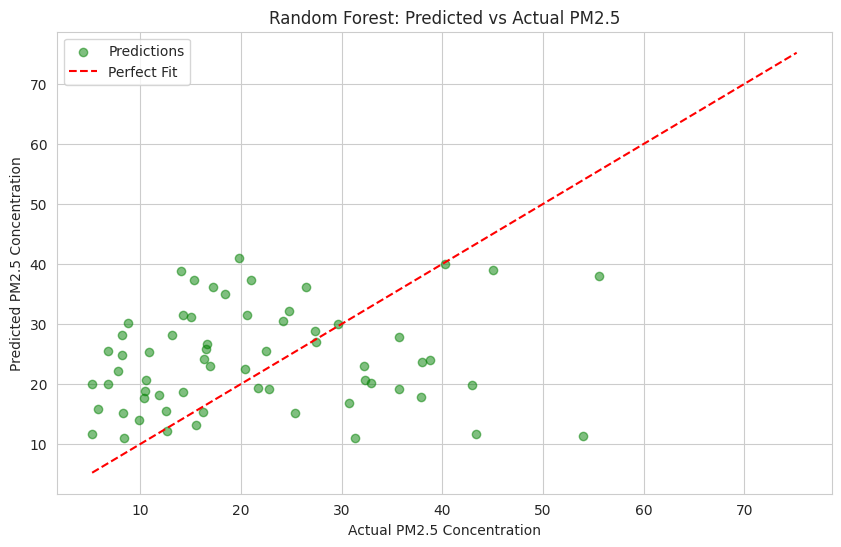

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, alpha=0.5, color='green', label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual PM2.5 Concentration')
plt.ylabel('Predicted PM2.5 Concentration')
plt.title('Random Forest: Predicted vs Actual PM2.5')
plt.legend()
plt.grid(True)
plt.savefig('rf_pred_vs_actual.png')
plt.show()


# Feature Importance for Random Forest

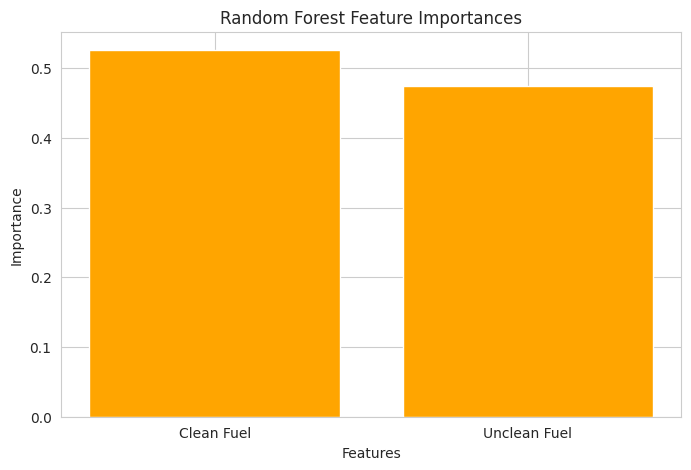

In [ ]:
plt.figure(figsize=(8, 5))
features = ['Clean Fuel', 'Unclean Fuel']
importances = rf_model.feature_importances_
plt.bar(features, importances, color='orange')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.savefig('rf_feature_importance.png')
plt.show()

# Residual Plot for Linear Regression Evaluation

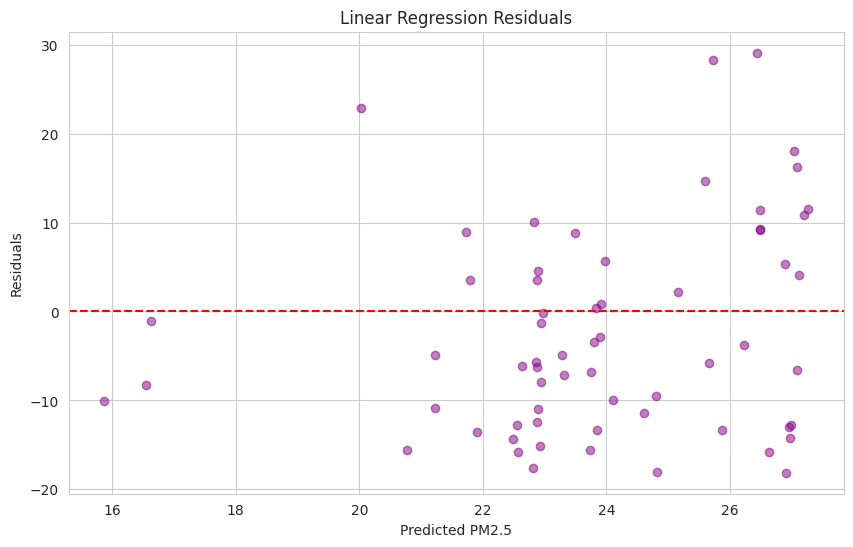

In [ ]:
residuals = y_test - lr_pred
plt.figure(figsize=(10, 6))
plt.scatter(lr_pred, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Residuals')
plt.title('Linear Regression Residuals')
plt.grid(True)
plt.savefig('lr_residuals.png')
plt.show()

# STEP 7: COUNTRY-SPECIFIC ANALYSIS



[STEP 7] COUNTRY-SPECIFIC ANALYSIS
--------------------------------------------------------------------------------

Top 10 Countries with Highest PM 2.5 Concentration:
     Country  PM25_Concentration        AQI  PM25_Low    AQI_Low  PM25_High   AQI_High  Clean  Unclean Residence_Type
 Afghanistan               75.19 161.166596     53.87 146.232663     102.90 175.474183  82.80     15.0          Urban
       Egypt               64.10 155.440464     40.90 114.296482      93.85 170.801370  99.40      0.0          Urban
    Cameroon               61.63 154.165121     41.27 115.207538      85.12 166.293783  44.40     53.9          Urban
Saudi Arabia               60.73 153.700421     44.71 123.677889      79.64 163.464278  98.60      0.0          Urban
       Qatar               59.96 153.302845     46.36 127.740704      72.52 159.787987  99.00      0.0          Urban
  Tajikistan               56.80 151.671233     41.78 116.463317      79.67 163.479768  96.20      1.4          Urban
Sau

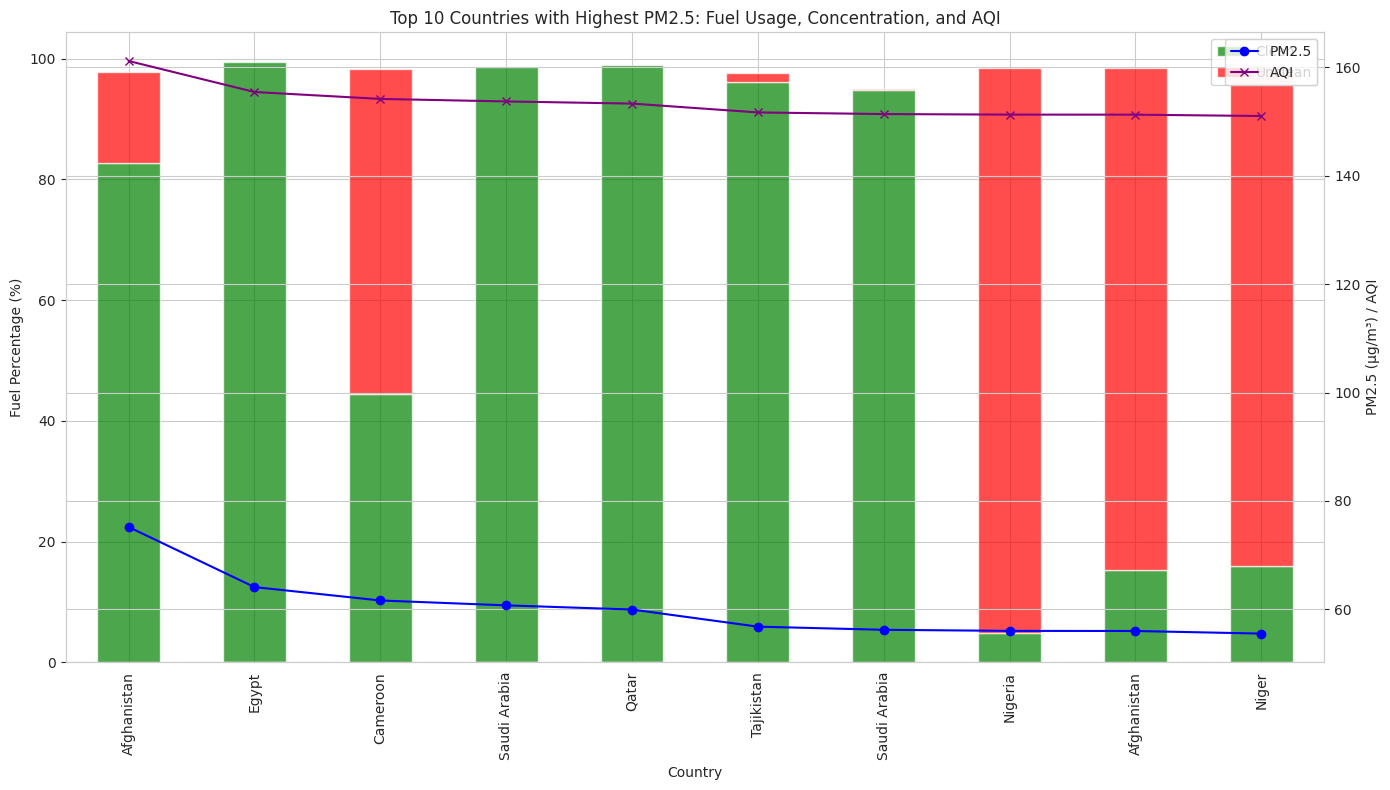

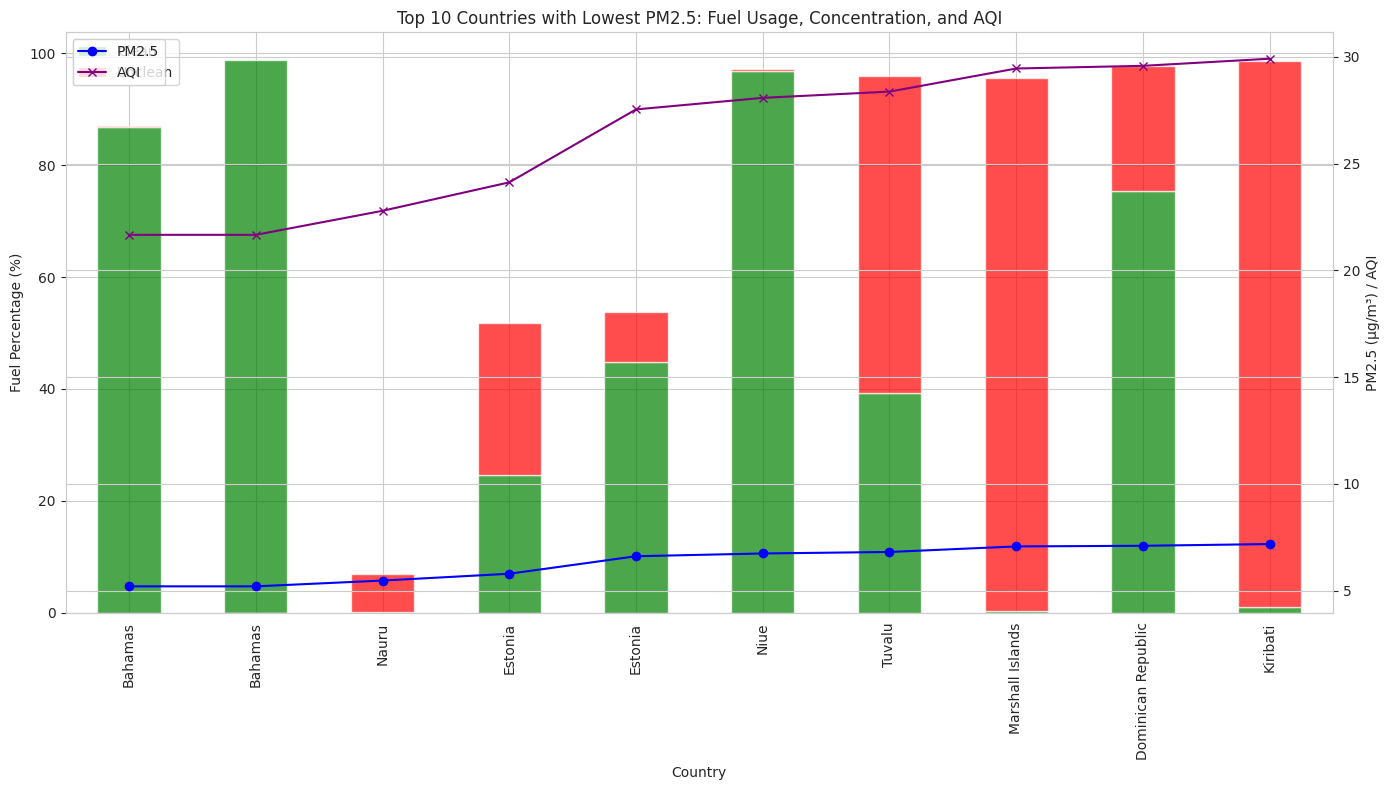

In [40]:
print("\n\n[STEP 7] COUNTRY-SPECIFIC ANALYSIS")
print("-" * 80)

# Top 10 countries by PM 2.5
print("\nTop 10 Countries with Highest PM 2.5 Concentration:")
top_polluted = merged_df.nlargest(10, 'PM25_Concentration')[
    ['Country', 'PM25_Concentration', 'AQI', 'PM25_Low', 'AQI_Low', 'PM25_High', 'AQI_High', 'Clean', 'Unclean', 'Residence_Type']
]
print(top_polluted.to_string(index=False))

print("\n\nTop 10 Countries with Lowest PM 2.5 Concentration:")
top_clean = merged_df.nsmallest(10, 'PM25_Concentration')[
    ['Country', 'PM25_Concentration', 'AQI', 'PM25_Low', 'AQI_Low', 'PM25_High', 'AQI_High', 'Clean', 'Unclean', 'Residence_Type']
]
print(top_clean.to_string(index=False))

# Updated Bar Chart for Top 10 Highest PM2.5 Countries (add AQI line)
fig, ax1 = plt.subplots(figsize=(14, 8))
top_polluted.plot(x='Country', y=['Clean', 'Unclean'], kind='bar', stacked=True, ax=ax1, color=['green', 'red'], alpha=0.7)
ax1.set_ylabel('Fuel Percentage (%)')
ax1.set_title('Top 10 Countries with Highest PM2.5: Fuel Usage, Concentration, and AQI')
ax2 = ax1.twinx()
top_polluted.plot(x='Country', y='PM25_Concentration', kind='line', ax=ax2, color='blue', marker='o', label='PM2.5')
top_polluted.plot(x='Country', y='AQI', kind='line', ax=ax2, color='purple', marker='x', label='AQI')
ax2.set_ylabel('PM2.5 (μg/m³) / AQI')
ax2.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_polluted_countries_with_aqi.png')
plt.show()

# Similar for Top Clean
fig, ax1 = plt.subplots(figsize=(14, 8))
top_clean.plot(x='Country', y=['Clean', 'Unclean'], kind='bar', stacked=True, ax=ax1, color=['green', 'red'], alpha=0.7)
ax1.set_ylabel('Fuel Percentage (%)')
ax1.set_title('Top 10 Countries with Lowest PM2.5: Fuel Usage, Concentration, and AQI')
ax2 = ax1.twinx()
top_clean.plot(x='Country', y='PM25_Concentration', kind='line', ax=ax2, color='blue', marker='o', label='PM2.5')
top_clean.plot(x='Country', y='AQI', kind='line', ax=ax2, color='purple', marker='x', label='AQI')
ax2.set_ylabel('PM2.5 (μg/m³) / AQI')
ax2.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_clean_countries_with_aqi.png')
plt.show()

# STEP 8: AQI ANALYSIS AND VISUALIZATION



[STEP 8] AQI ANALYSIS AND VISUALIZATION
--------------------------------------------------------------------------------

AQI Descriptive Statistics:
              AQI     AQI_Low    AQI_High
count  312.000000  312.000000  312.000000
mean    77.352477   54.366836  100.586798
std     52.577498   36.908181   58.310918
min     21.666667    6.666667   26.791667
25%     52.235515   31.072917   61.210086
50%     67.224678   53.376395   78.885837
75%     93.475429   67.918670  143.758040
max    500.000000  500.000000  500.000000


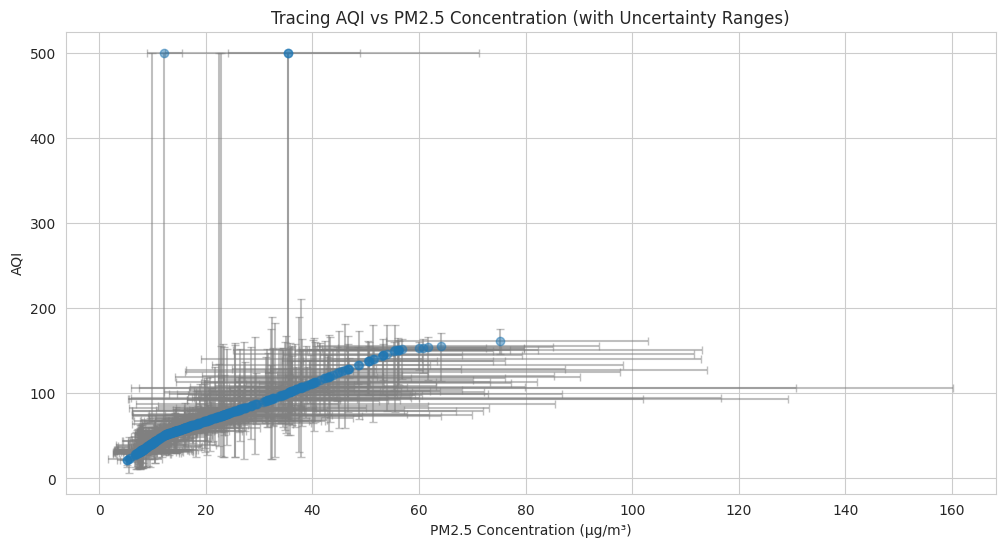

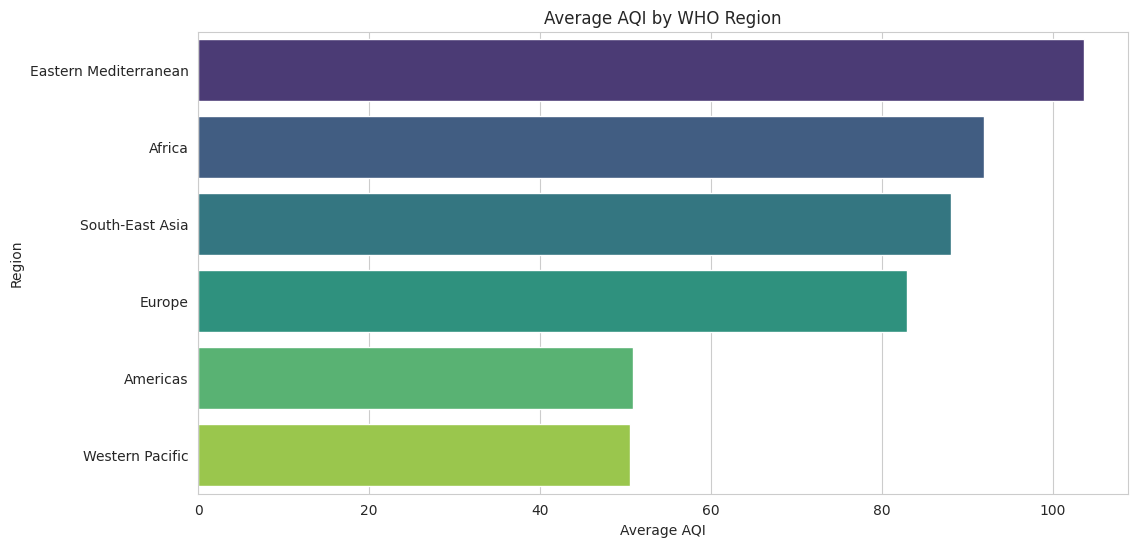

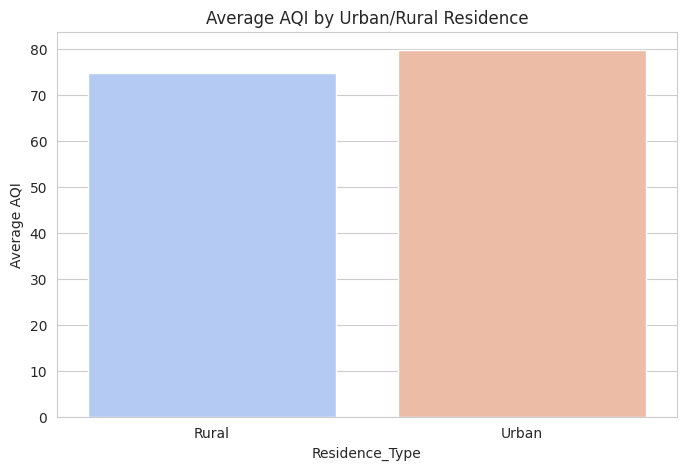

In [41]:
print("\n\n[STEP 8] AQI ANALYSIS AND VISUALIZATION")
print("-" * 80)

# Summary statistics for AQI
print("\nAQI Descriptive Statistics:")
print(merged_df[['AQI', 'AQI_Low', 'AQI_High']].describe())

# Scatter Plot: Tracing AQI vs PM2.5 (with error bars for low/high)
plt.figure(figsize=(12, 6))

merged_df = merged_df[(merged_df['PM25_Low'] <= merged_df['PM25_Concentration']) & (merged_df['PM25_Concentration'] <= merged_df['PM25_High'])]
plt.errorbar(merged_df['PM25_Concentration'], merged_df['AQI'],
xerr = [np.maximum(0, merged_df['PM25_Concentration'] - merged_df['PM25_Low']),
        np.maximum(0, merged_df['PM25_High'] - merged_df['PM25_Concentration'])],
yerr = [np.maximum(0, merged_df['AQI'] - merged_df['AQI_Low']),
        np.maximum(0, merged_df['AQI_High'] - merged_df['AQI'])],
             fmt='o', alpha=0.5, ecolor='gray', capsize=3)
plt.xlabel('PM2.5 Concentration (μg/m³)')
plt.ylabel('AQI')
plt.title('Tracing AQI vs PM2.5 Concentration (with Uncertainty Ranges)')
plt.grid(True)
plt.savefig('aqi_vs_pm25_scatter.png')
plt.show()

# Bar Chart: Average AQI by WHO Region
region_aqi = merged_df.groupby('Region_x')['AQI'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='AQI', y='Region_x', data=region_aqi, palette='viridis')
plt.title('Average AQI by WHO Region')
plt.xlabel('Average AQI')
plt.ylabel('Region')
plt.savefig('average_aqi_by_region.png')
plt.show()

# Bar Chart: Average AQI by Residence Type
residence_aqi = merged_df.groupby('Residence_Type')['AQI'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='Residence_Type', y='AQI', data=residence_aqi, palette='coolwarm')
plt.title('Average AQI by Urban/Rural Residence')
plt.ylabel('Average AQI')
plt.savefig('average_aqi_by_residence.png')
plt.show()